In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

import pandas as pd
import numpy as np
import os
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.__version__

'0.12.0'

In [3]:
pd.__version__

'1.3.4'

In [4]:
#perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/uniref90/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240702/sars-cov-2/uniref90/cov-S-multi-transfer_learning_mlm_hybrid_attn_fnn_2l_lr1e-4/aligned_msl256_s64/processed")

human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
classes=["Cat", "Chicken", "Chinese rufous horseshoe bat", "Ferret", "Gray wolf", "Horshoe bat", "Human", "Pig"]

In [5]:
def get_perturbation_output(perturbation_processed_output_dir):
    perturbation_output_files = os.listdir(perturbation_processed_output_dir)
    print(f"Number of perturbation output files = {len(perturbation_output_files)}")

    perturbed_output_dfs = []
    for perturbation_output_file in perturbation_output_files:
        df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
        orig_seq_df = df[df["orig_token"] == df["new_token"]]
        orig_pred_val = orig_seq_df[human_label].values[0]
        orig_pred_class = orig_seq_df[classes].idxmax(axis=1).values[0]

        
        df[pred_diff_col] = df[human_label] - orig_pred_val
        df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
        df["orig_y_pred"] = orig_pred_class
        df["new_y_pred"] = df[classes].idxmax(axis=1)
    
        perturbed_output_dfs.append(df)
    return pd.concat(perturbed_output_dfs)

In [6]:
import textwrap
def wrap_xticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_xticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_xticklabels(wrapped_labels, rotation=0)
    
def wrap_yticklabels(ax, label_width=10, break_long_words=False):
    wrapped_labels = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        wrapped_labels.append(textwrap.fill(text=label_text, width=label_width, break_long_words=break_long_words))
    ax.set_yticklabels(wrapped_labels, rotation=0)
    
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

In [7]:
perturbed_output_df = get_perturbation_output(perturbation_processed_output_dir)
perturbed_output_df = perturbed_output_df[(perturbed_output_df["orig_token"] != "X") & (perturbed_output_df["new_token"] != "X")]
print(f"perturbed_output_df shape = {perturbed_output_df.shape}")

Number of perturbation output files = 94
perturbed_output_df shape = (2500798, 17)



#### WIV04 reference sequence

In [8]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/alignment/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

uniref90_id                                        aligned_seq  \
0       WIV04  --------------MFVFLVLLPLVSS--------Q----------...   

                                                 seq  \
0  MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...   

                                    virus_name virus_host_name  \
0  WIV04(MN996528.1) Wuhan variant index virus    homo sapiens   

  human_binary_label  
0       homo sapiens

In [9]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
print(len(wiv04_aligned_seq))
wiv04_aligned_seq

2418


'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [10]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = int(pos)
        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)        
perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_seq_pos"].astype("Int64")

In [11]:
perturbed_output_df

Cat       Chicken  Chinese rufous horseshoe bat        Ferret  \
0      2.118620e-02  1.006803e-03                      0.027980  3.616932e-04   
1      1.332227e-04  1.565423e-05                      0.035062  7.828845e-06   
2      1.307081e-04  1.537743e-05                      0.035084  7.698174e-06   
3      1.508527e-04  1.634235e-05                      0.031951  7.884458e-06   
4      1.316033e-04  1.546554e-05                      0.035046  7.737340e-06   
...             ...           ...                           ...           ...   
31815  2.605461e-09  2.700193e-08                      0.000262  2.952911e-08   
31817  2.636858e-09  2.729180e-08                      0.000264  2.989567e-08   
31818  2.642305e-09  2.734321e-08                      0.000265  2.998056e-08   
31820  2.666720e-09  2.756310e-08                      0.000265  3.017120e-08   
31824  2.723558e-09  2.808546e-08                      0.000269  3.082450e-08   

       Gray wolf  Horshoe bat     Human           Pig          uniref90_id  \
0       0.040336     0.003458  0.904826  8.448291e-04  UniRef90_A0A7T6Y5W2   
1       0.000371     0.005713  0.958675  2.205715e-05  UniRef90_A0A7T6Y5W2   
2       0.000365     0.005713  0.958663  2.172473e-05  UniRef90_A0A7T6Y5W2   
3       0.000425     0.005027  0.962400  2.212432e-05  UniRef90_A0A7T6Y5W2   
4       0.000367     0.005706  0.958704  2.182397e-05  UniRef90_A0A7T6Y5W2   
...          ...          ...       ...           ...                  ...   
31815   0.000024     0.011421  0.988293  6.903743e-07  UniRef90_A0A8B1K2U2   
31817   0.000024     0.011484  0.988227  6.974502e-07  UniRef90_A0A8B1K2U2   
31818   0.000024     0.011508  0.988202  6.991652e-07  UniRef90_A0A8B1K2U2   
31820   0.000024     0.011500  0.988210  7.026656e-07  UniRef90_A0A8B1K2U2   
31824   0.000025     0.011607  0.988099  7.152042e-07  UniRef90_A0A8B1K2U2   

      y_true orig_token  perturb_pos new_token  Human_pred_diff  \
0      Human          K         2234         B        -0.053886   
1      Human          P         1840         H        -0.000038   
2      Human          Q         2010         T        -0.000050   
3      Human          D         1554         O         0.003687   
4      Human          A         2085         T        -0.000008   
...      ...        ...          ...       ...              ...   
31815  Human          G          859         B         0.000051   
31817  Human          N           79         B        -0.000014   
31818  Human          T         1557         A        -0.000040   
31820  Human          A         2328         I        -0.000031   
31824  Human          G         1825         V        -0.000142   

       abs_Human_pred_diff orig_y_pred new_y_pred  perturb_seq_pos  
0                 0.053886       Human      Human             1149  
1                 0.000038       Human      Human              807  
2                 0.000050       Human      Human              949  
3                 0.003687       Human      Human              578  
4                 0.000008       Human      Human             1022  
...                    ...         ...        ...              ...  
31815             0.000051       Human      Human              339  
31817             0.000014       Human      Human               30  
31818             0.000040       Human      Human              581  
31820             0.000031       Human      Human             1226  
31824             0.000142       Human      Human              799  

[2500798 rows x 18 columns]

In [12]:
perturbed_output_df = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isna()]

In [13]:
perturbed_output_df

Cat       Chicken  Chinese rufous horseshoe bat        Ferret  \
0      2.118620e-02  1.006803e-03                      0.027980  3.616932e-04   
1      1.332227e-04  1.565423e-05                      0.035062  7.828845e-06   
2      1.307081e-04  1.537743e-05                      0.035084  7.698174e-06   
3      1.508527e-04  1.634235e-05                      0.031951  7.884458e-06   
4      1.316033e-04  1.546554e-05                      0.035046  7.737340e-06   
...             ...           ...                           ...           ...   
31815  2.605461e-09  2.700193e-08                      0.000262  2.952911e-08   
31817  2.636858e-09  2.729180e-08                      0.000264  2.989567e-08   
31818  2.642305e-09  2.734321e-08                      0.000265  2.998056e-08   
31820  2.666720e-09  2.756310e-08                      0.000265  3.017120e-08   
31824  2.723558e-09  2.808546e-08                      0.000269  3.082450e-08   

       Gray wolf  Horshoe bat     Human           Pig          uniref90_id  \
0       0.040336     0.003458  0.904826  8.448291e-04  UniRef90_A0A7T6Y5W2   
1       0.000371     0.005713  0.958675  2.205715e-05  UniRef90_A0A7T6Y5W2   
2       0.000365     0.005713  0.958663  2.172473e-05  UniRef90_A0A7T6Y5W2   
3       0.000425     0.005027  0.962400  2.212432e-05  UniRef90_A0A7T6Y5W2   
4       0.000367     0.005706  0.958704  2.182397e-05  UniRef90_A0A7T6Y5W2   
...          ...          ...       ...           ...                  ...   
31815   0.000024     0.011421  0.988293  6.903743e-07  UniRef90_A0A8B1K2U2   
31817   0.000024     0.011484  0.988227  6.974502e-07  UniRef90_A0A8B1K2U2   
31818   0.000024     0.011508  0.988202  6.991652e-07  UniRef90_A0A8B1K2U2   
31820   0.000024     0.011500  0.988210  7.026656e-07  UniRef90_A0A8B1K2U2   
31824   0.000025     0.011607  0.988099  7.152042e-07  UniRef90_A0A8B1K2U2   

      y_true orig_token  perturb_pos new_token  Human_pred_diff  \
0      Human          K         2234         B        -0.053886   
1      Human          P         1840         H        -0.000038   
2      Human          Q         2010         T        -0.000050   
3      Human          D         1554         O         0.003687   
4      Human          A         2085         T        -0.000008   
...      ...        ...          ...       ...              ...   
31815  Human          G          859         B         0.000051   
31817  Human          N           79         B        -0.000014   
31818  Human          T         1557         A        -0.000040   
31820  Human          A         2328         I        -0.000031   
31824  Human          G         1825         V        -0.000142   

       abs_Human_pred_diff orig_y_pred new_y_pred  perturb_seq_pos  
0                 0.053886       Human      Human             1149  
1                 0.000038       Human      Human              807  
2                 0.000050       Human      Human              949  
3                 0.003687       Human      Human              578  
4                 0.000008       Human      Human             1022  
...                    ...         ...        ...              ...  
31815             0.000051       Human      Human              339  
31817             0.000014       Human      Human               30  
31818             0.000040       Human      Human              581  
31820             0.000031       Human      Human             1226  
31824             0.000142       Human      Human              799  

[2498662 rows x 18 columns]

# Overview

### Distribution of Human class difference

In [14]:
def print_histogram(distribution, n_bins=20):
    n = distribution.shape[0]
    print(f"n={n}")
    freq, bins = np.histogram(distribution, bins=n_bins)
    hist_map = []
    for i in range(n_bins):
        hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    hist_df = pd.DataFrame(hist_map)
    print(hist_df.head(20))

In [15]:
selected_df = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
print(f"Number of sequences with abs_{pred_diff_col} >= 0.1: {selected_df.shape[0]} ({selected_df.shape[0]/perturbed_output_df.shape[0]*100})")

print("Distribution of full perturbation output")
print_histogram(perturbed_output_df[pred_diff_col], n_bins=20)
print("\n>>>>>>>>>>>>><<<<<<<<<<<<<<<<\n")
print(f"Distribution of perturbation output with |{pred_diff_col}| >= 0.1")
print_histogram(selected_df[pred_diff_col], n_bins=20)

Number of sequences with abs_Human_pred_diff >= 0.1: 8956 (0.35843183271687007)
Distribution of full perturbation output
n=2498662
       start       end    count  percentage
0  -0.948433 -0.899308      587    0.023493
1  -0.899308 -0.850183      129    0.005163
2  -0.850183 -0.801058     1813    0.072559
3  -0.801058 -0.751933       70    0.002801
4  -0.751933 -0.702808       67    0.002681
5  -0.702808 -0.653683      872    0.034899
6  -0.653683 -0.604558       79    0.003162
7  -0.604558 -0.555433       84    0.003362
8  -0.555433 -0.506308       28    0.001121
9  -0.506308 -0.457183       59    0.002361
10 -0.457183 -0.408059       35    0.001401
11 -0.408059 -0.358934       50    0.002001
12 -0.358934 -0.309809       60    0.002401
13 -0.309809 -0.260684       61    0.002441
14 -0.260684 -0.211559      888    0.035539
15 -0.211559 -0.162434      232    0.009285
16 -0.162434 -0.113309     2039    0.081604
17 -0.113309 -0.064184     4363    0.174613
18 -0.064184 -0.015059     7973  

<Figure size 432x288 with 0 Axes>

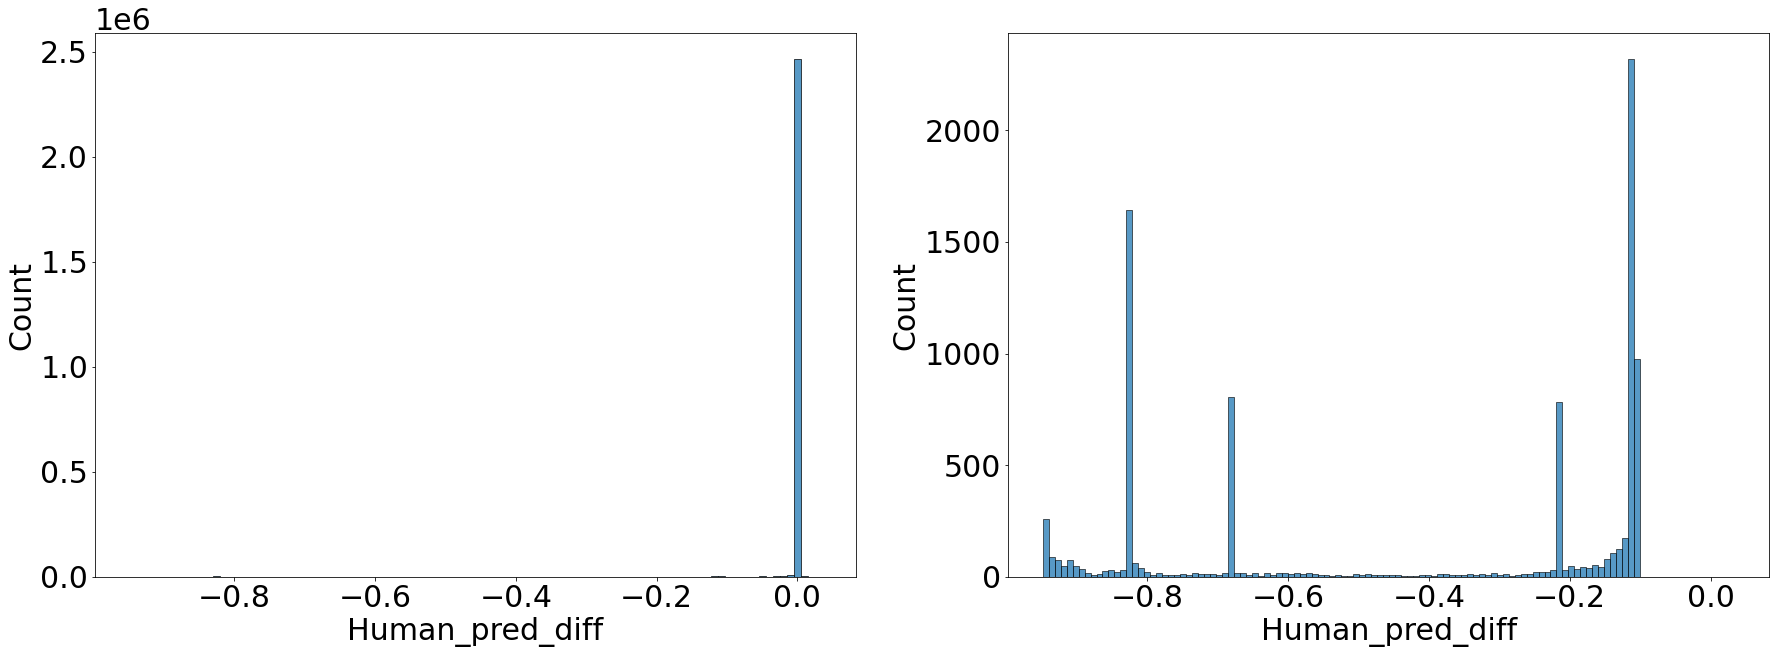

In [16]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
fig, axs = plt.subplots(1, 2, figsize=(30, 10), sharex=True, sharey=False)

sns.histplot(perturbed_output_df["Human_pred_diff"], bins=100, ax=axs[0])
sns.histplot(selected_df["Human_pred_diff"], bins=100, ax=axs[1])
plt.show()



### Distribution of Human pred diff in each position

<Figure size 432x288 with 0 Axes>

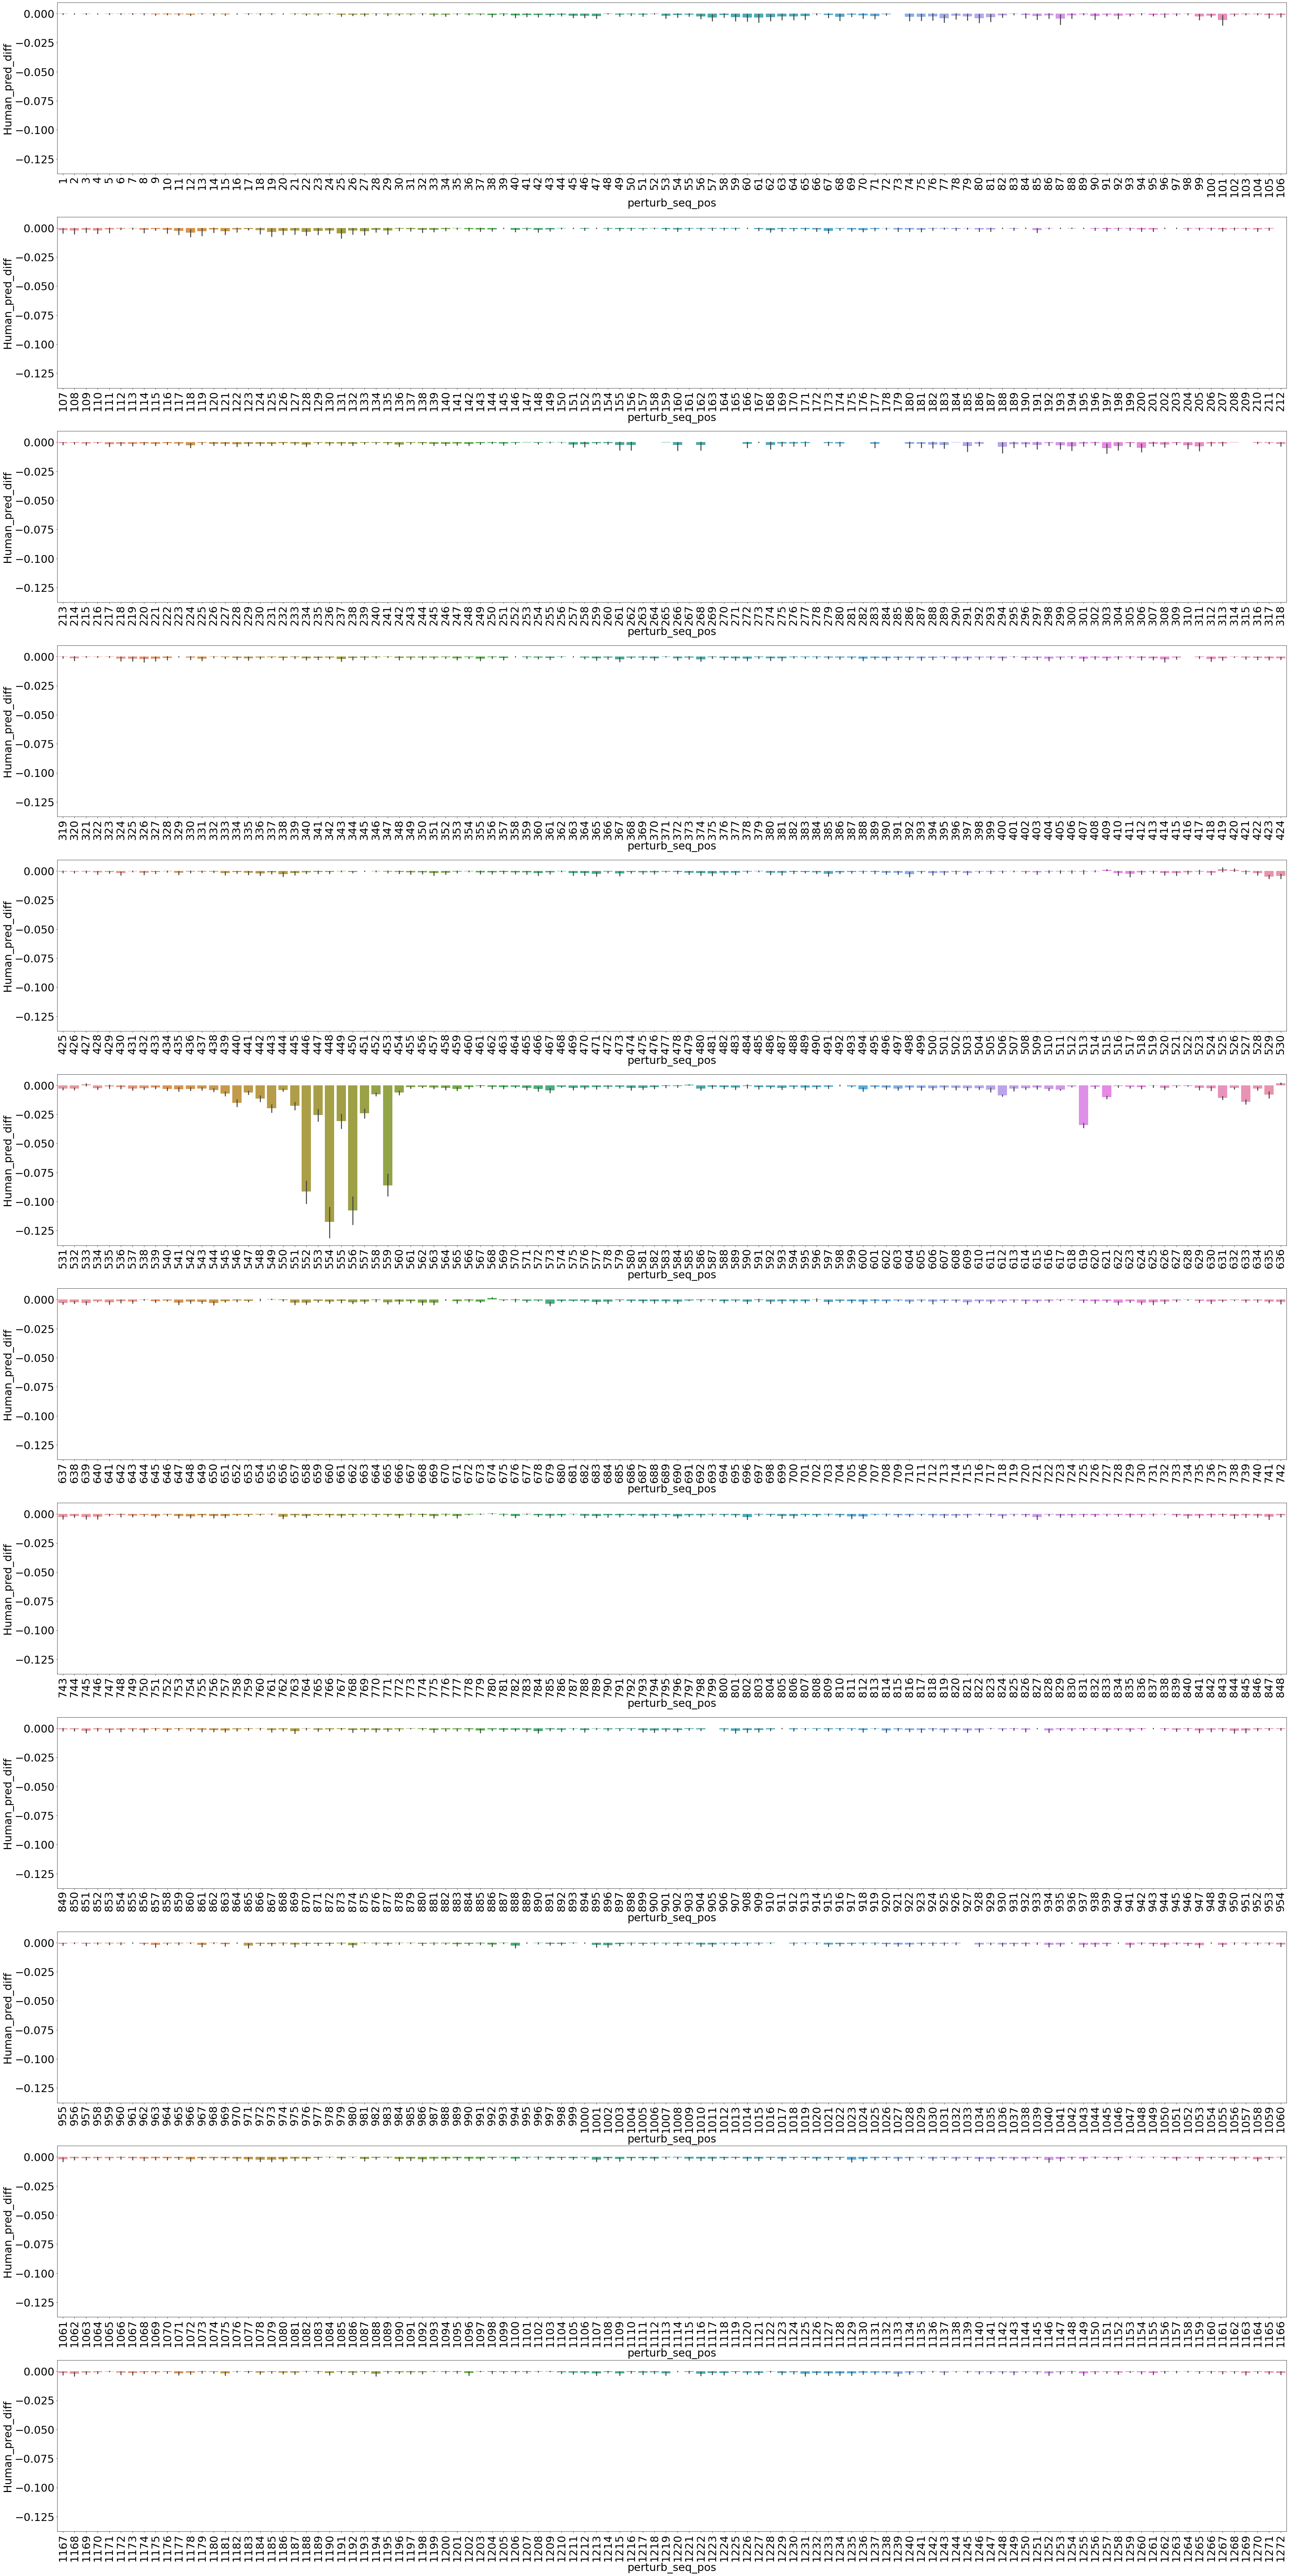

In [17]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
n = 12
fig, axs = plt.subplots(n, 1, figsize=(50, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(sorted(perturbed_output_df["perturb_seq_pos"].unique())), n)

for i in range(n):
    sns.barplot(perturbed_output_df[perturbed_output_df["perturb_seq_pos"].isin(bins[i])], x="perturb_seq_pos", y=pred_diff_col, ax=axs[i])
    axs[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.1)
plt.show()

In [18]:
perturbed_output_df[(perturbed_output_df["perturb_seq_pos"] > 500) & (perturbed_output_df["abs_Human_pred_diff"] > 0)]

Cat       Chicken  Chinese rufous horseshoe bat        Ferret  \
0      2.118620e-02  1.006803e-03                      0.027980  3.616932e-04   
1      1.332227e-04  1.565423e-05                      0.035062  7.828845e-06   
2      1.307081e-04  1.537743e-05                      0.035084  7.698174e-06   
3      1.508527e-04  1.634235e-05                      0.031951  7.884458e-06   
4      1.316033e-04  1.546554e-05                      0.035046  7.737340e-06   
...             ...           ...                           ...           ...   
31811  2.434260e-09  2.545572e-08                      0.000263  2.830425e-08   
31812  2.617742e-09  2.711684e-08                      0.000263  2.970006e-08   
31818  2.642305e-09  2.734321e-08                      0.000265  2.998056e-08   
31820  2.666720e-09  2.756310e-08                      0.000265  3.017120e-08   
31824  2.723558e-09  2.808546e-08                      0.000269  3.082450e-08   

       Gray wolf  Horshoe bat     Human           Pig          uniref90_id  \
0       0.040336     0.003458  0.904826  8.448291e-04  UniRef90_A0A7T6Y5W2   
1       0.000371     0.005713  0.958675  2.205715e-05  UniRef90_A0A7T6Y5W2   
2       0.000365     0.005713  0.958663  2.172473e-05  UniRef90_A0A7T6Y5W2   
3       0.000425     0.005027  0.962400  2.212432e-05  UniRef90_A0A7T6Y5W2   
4       0.000367     0.005706  0.958704  2.182397e-05  UniRef90_A0A7T6Y5W2   
...          ...          ...       ...           ...                  ...   
31811   0.000023     0.011557  0.988156  6.676444e-07  UniRef90_A0A8B1K2U2   
31812   0.000024     0.011462  0.988250  6.937051e-07  UniRef90_A0A8B1K2U2   
31818   0.000024     0.011508  0.988202  6.991652e-07  UniRef90_A0A8B1K2U2   
31820   0.000024     0.011500  0.988210  7.026656e-07  UniRef90_A0A8B1K2U2   
31824   0.000025     0.011607  0.988099  7.152042e-07  UniRef90_A0A8B1K2U2   

      y_true orig_token  perturb_pos new_token  Human_pred_diff  \
0      Human          K         2234         B        -0.053886   
1      Human          P         1840         H        -0.000038   
2      Human          Q         2010         T        -0.000050   
3      Human          D         1554         O         0.003687   
4      Human          A         2085         T        -0.000008   
...      ...        ...          ...       ...              ...   
31811  Human          N         1647         O        -0.000085   
31812  Human          A         1977         T         0.000008   
31818  Human          T         1557         A        -0.000040   
31820  Human          A         2328         I        -0.000031   
31824  Human          G         1825         V        -0.000142   

       abs_Human_pred_diff orig_y_pred new_y_pred  perturb_seq_pos  
0                 0.053886       Human      Human             1149  
1                 0.000038       Human      Human              807  
2                 0.000050       Human      Human              949  
3                 0.003687       Human      Human              578  
4                 0.000008       Human      Human             1022  
...                    ...         ...        ...              ...  
31811             0.000085       Human      Human              657  
31812             0.000008       Human      Human              930  
31818             0.000040       Human      Human              581  
31820             0.000031       Human      Human             1226  
31824             0.000142       Human      Human              799  

[1651832 rows x 18 columns]

### Cut-off: mean=0 and variance=0

In [19]:
mean_std_df = perturbed_output_df.groupby("perturb_seq_pos").agg(mean=(pred_diff_col, "mean"), std=(pred_diff_col, "std")).reset_index()
cut_off_pos = list(mean_std_df[(mean_std_df["mean"] == 0) & (mean_std_df["std"] == 0)]["perturb_seq_pos"].values)
cut_off_df_1 = perturbed_output_df[~perturbed_output_df["perturb_seq_pos"].isin(cut_off_pos)]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
len(cut_off_pos_1)

1273

<Figure size 432x288 with 0 Axes>

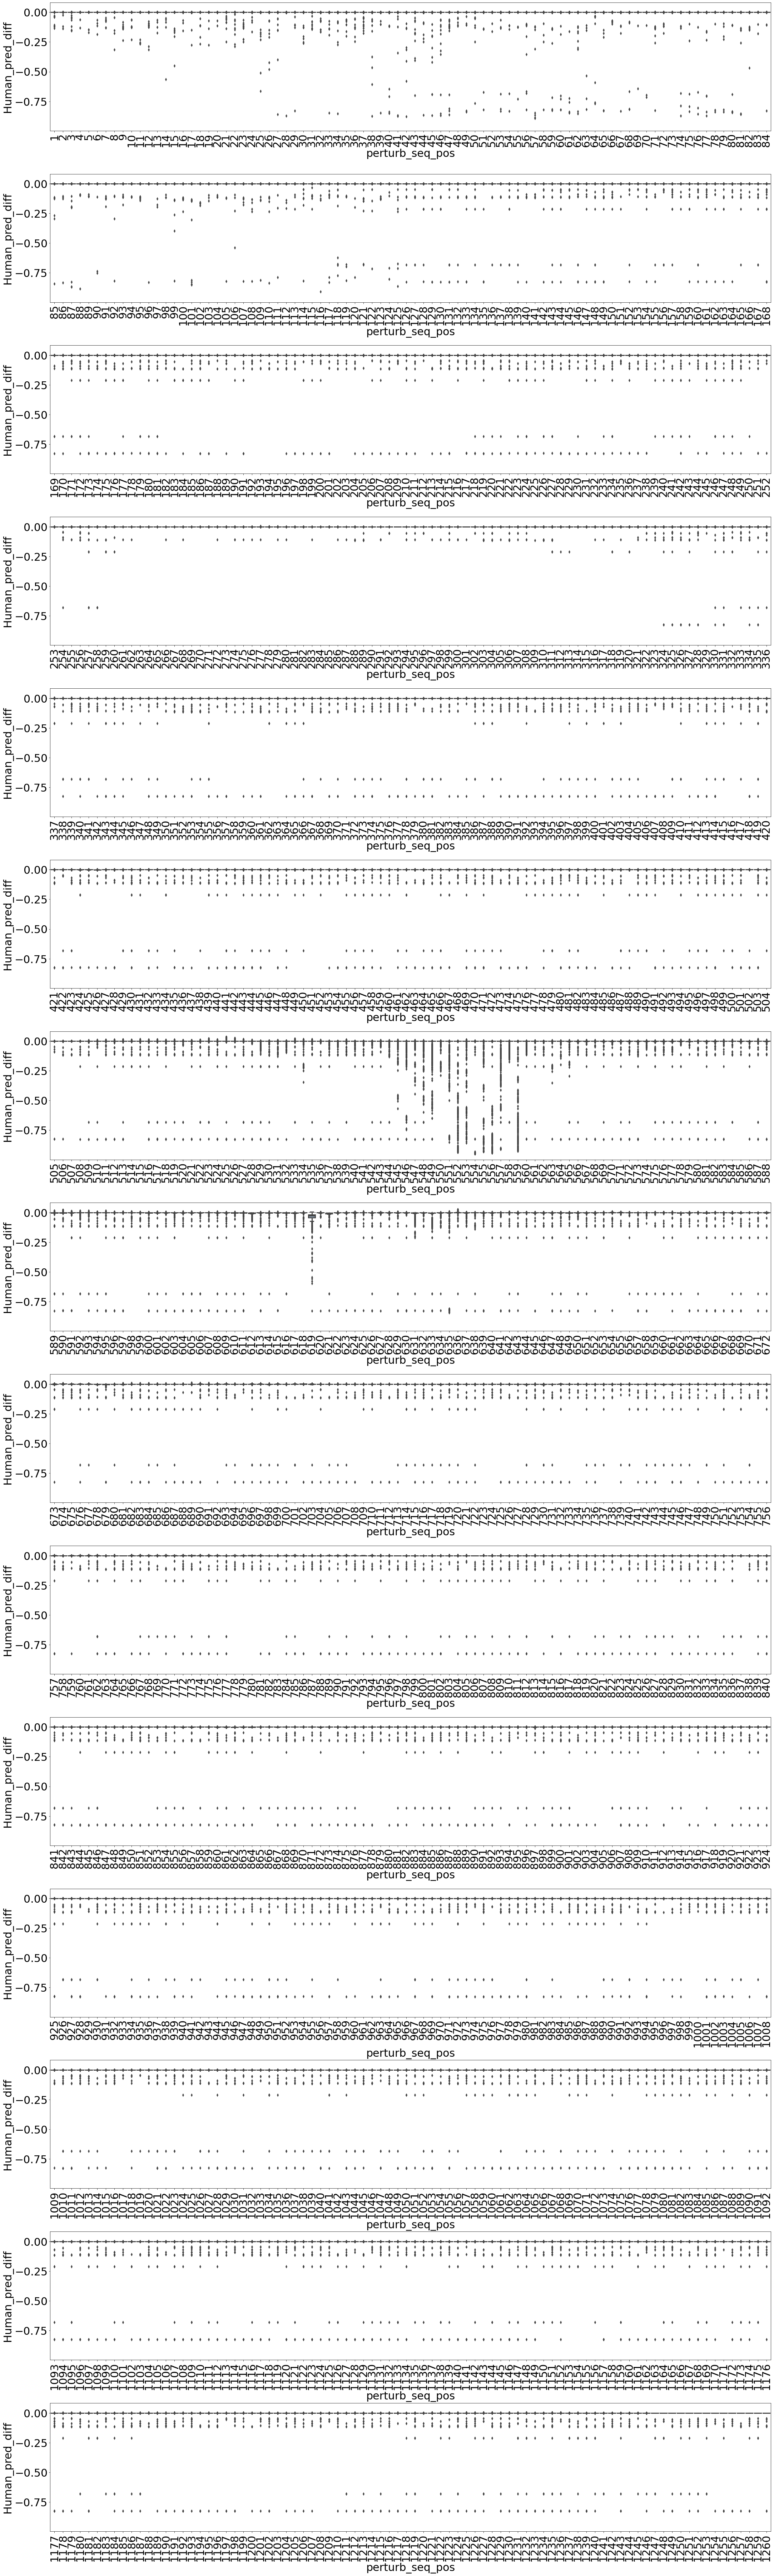

In [20]:
plt.clf()
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams.update({'font.size': 30})
n = 15
fig, axs = plt.subplots(n, 1, figsize=(30, 100), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(cut_off_pos_1), n)

for i in range(n):
    sns.boxplot(data=cut_off_df_1[cut_off_df_1["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")
    
plt.tight_layout(pad=.1)
plt.show()

### Cut-off: abs_Human_pred_diff >= 0.1

In [21]:
cut_off_df_2 = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] >= 0.1]
cut_off_pos_1 = set(cut_off_df_1["perturb_seq_pos"].unique())
cut_off_pos_2 = set(cut_off_df_2["perturb_seq_pos"].unique())
print(f"1. Number of unique positions with mean !=0 and variance != 0 : {len(cut_off_pos_1)}")
print(f"2. Number of unique positions with abs_{pred_diff_col} > 0.1 : {len(cut_off_pos_2)}")

print(f"1 intersection 2: {len(cut_off_pos_1.intersection(cut_off_pos_2))}")
print(f"1 minus 2: {len(cut_off_pos_1 - cut_off_pos_2)}")
print(f"2 minus 1: {len(cut_off_pos_2 - cut_off_pos_1)}")
print(f"is 2 subset of 1: {cut_off_pos_2 <= cut_off_pos_1}")

1. Number of unique positions with mean !=0 and variance != 0 : 1273
2. Number of unique positions with abs_Human_pred_diff > 0.1 : 1242
1 intersection 2: 1242
1 minus 2: 31
2 minus 1: 0
is 2 subset of 1: True


<Figure size 432x288 with 0 Axes>

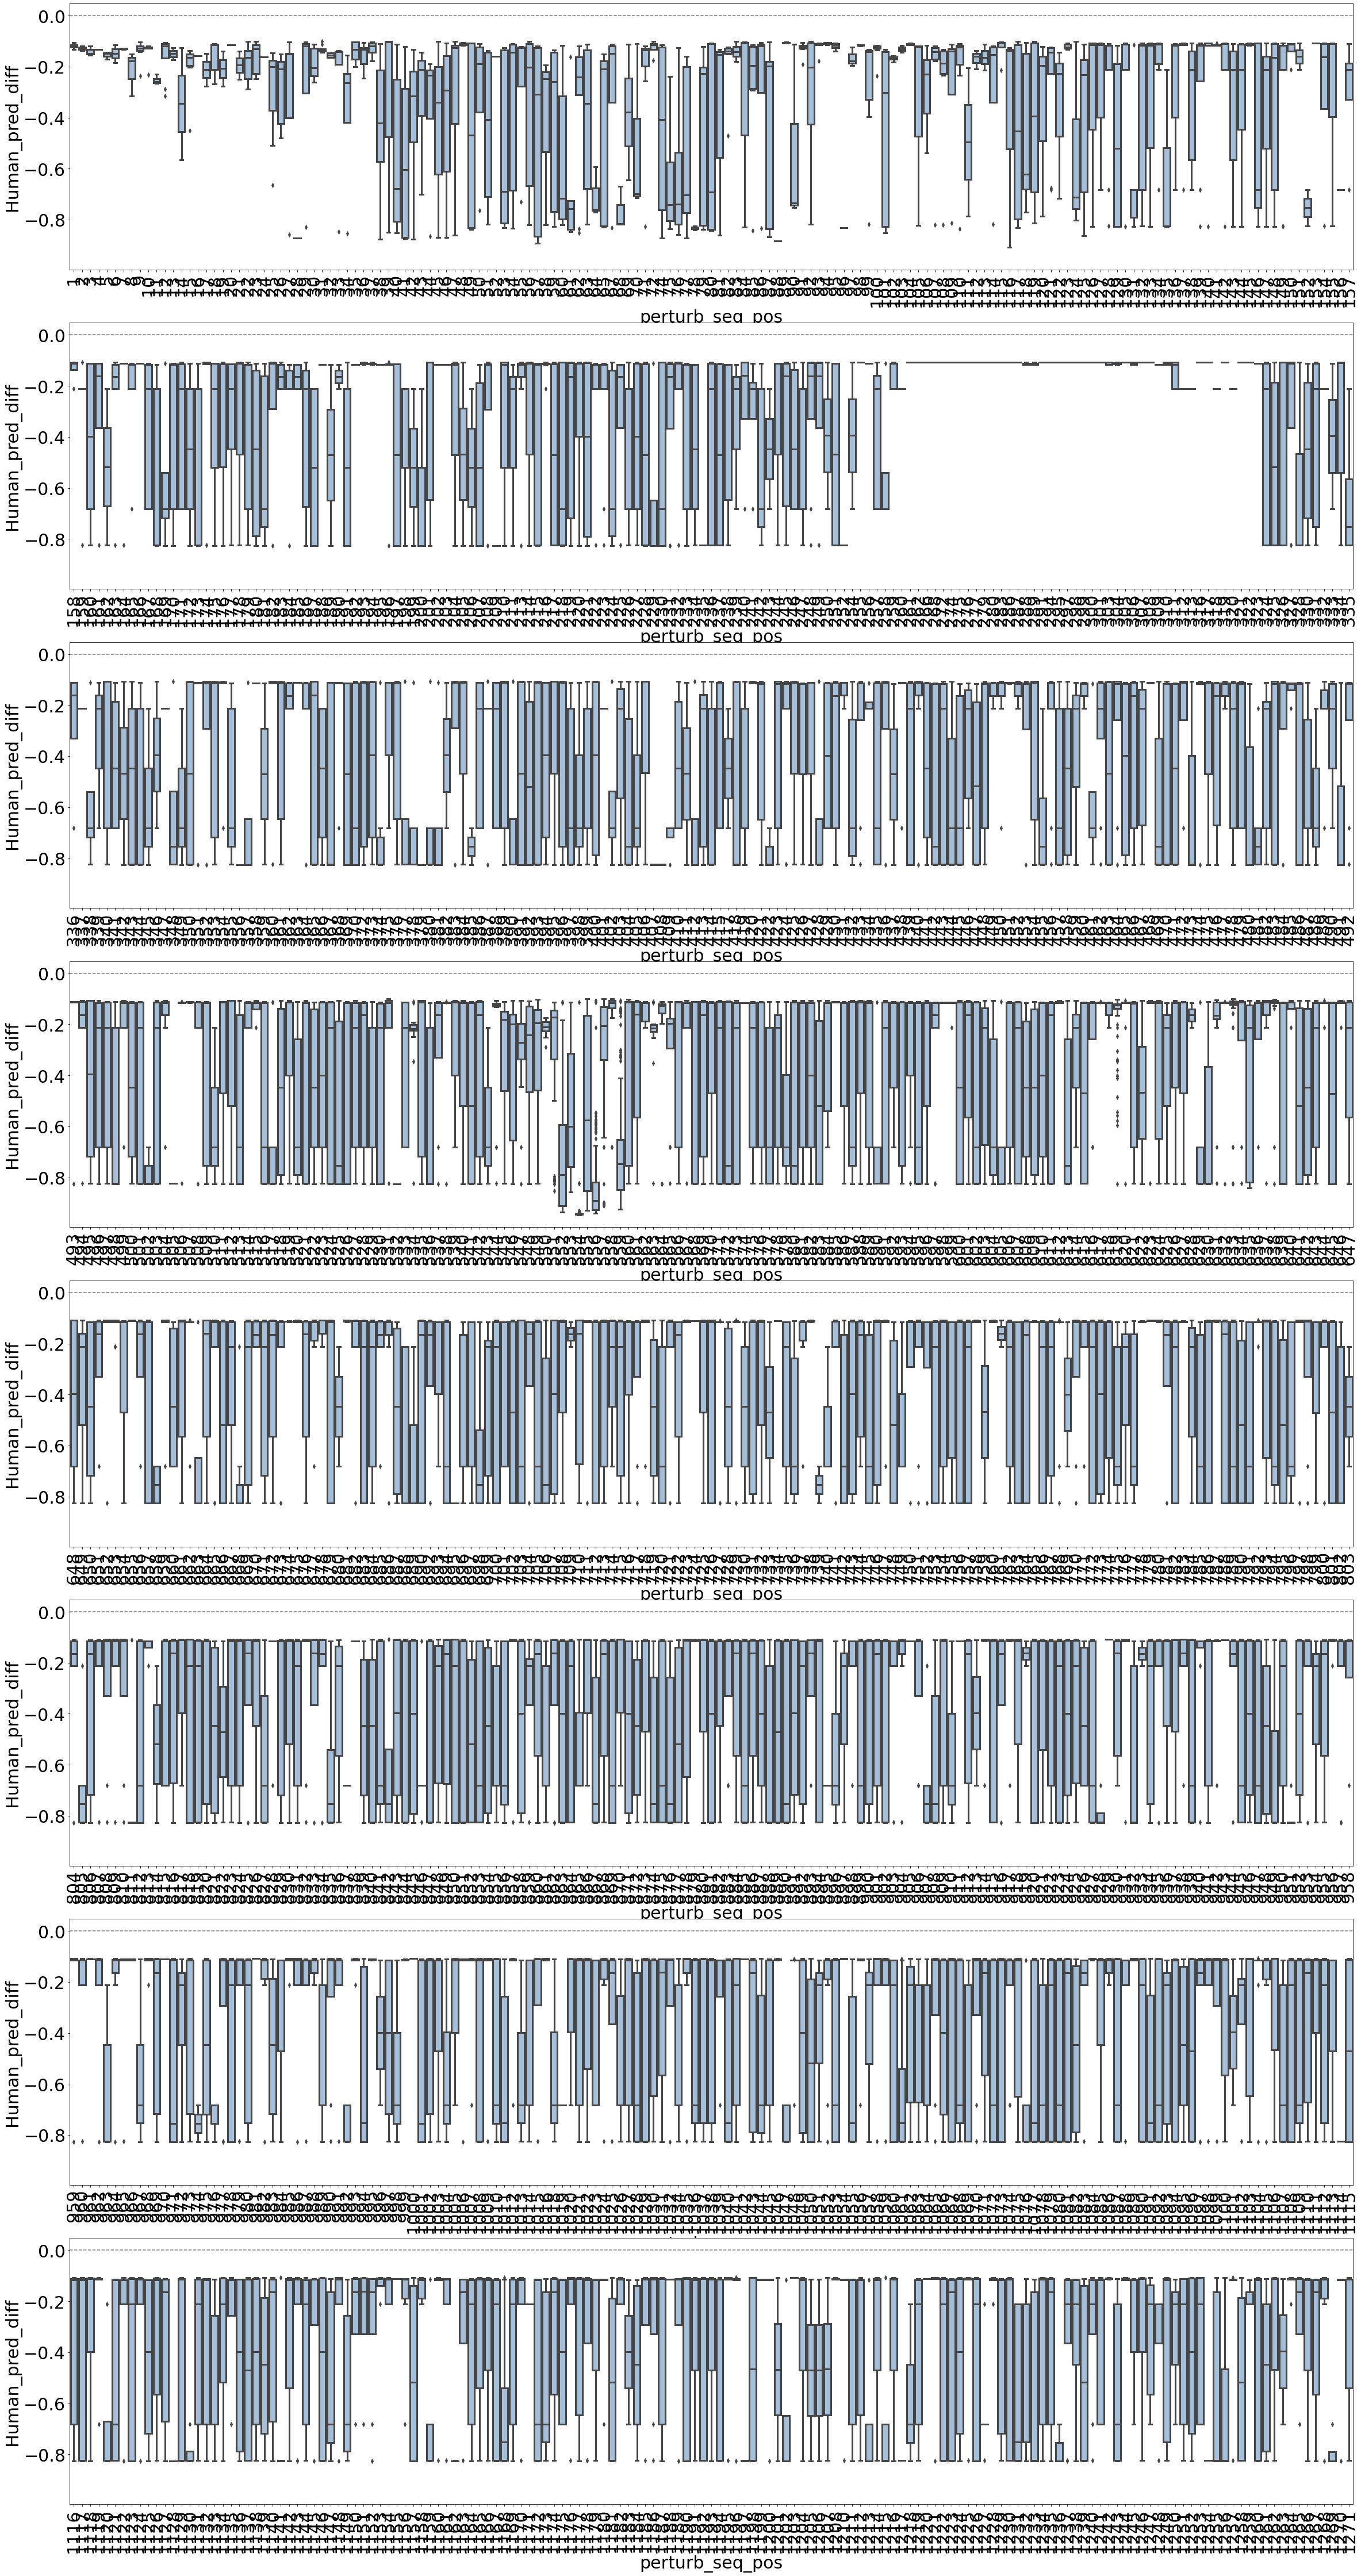

In [35]:
plt.clf()

n = 8
fig, axs = plt.subplots(n, 1, figsize=(40, 80), sharey=True)
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

bins = get_uniformly_divided_position_bins(list(cut_off_pos_2), n)

for i in range(n):
    sns.boxplot(data=cut_off_df_2[cut_off_df_2["perturb_seq_pos"].isin(bins[i])],  y="Human_pred_diff", x="perturb_seq_pos", ax=axs[i], orient="v", 
                linewidth=3,
                boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    axs[i].axhline(0.0, color="gray", linestyle="--")

plt.show()


## Identified important mutations
**Cut-off: abs_Human_pred_diff >= 0.1**

### Mutations with new token=X

In [23]:
cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]
x_mutation_df = cut_off_df_2[cut_off_df_2["new_token"] == "X"]

/tmp/ipykernel_2190225/3142901934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_off_df_2["perturbation_id"] = cut_off_df_2["orig_token"] + cut_off_df_2["perturb_seq_pos"].astype("str") + cut_off_df_2["new_token"]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No non overlapping boxes found


<Figure size 432x288 with 0 Axes>

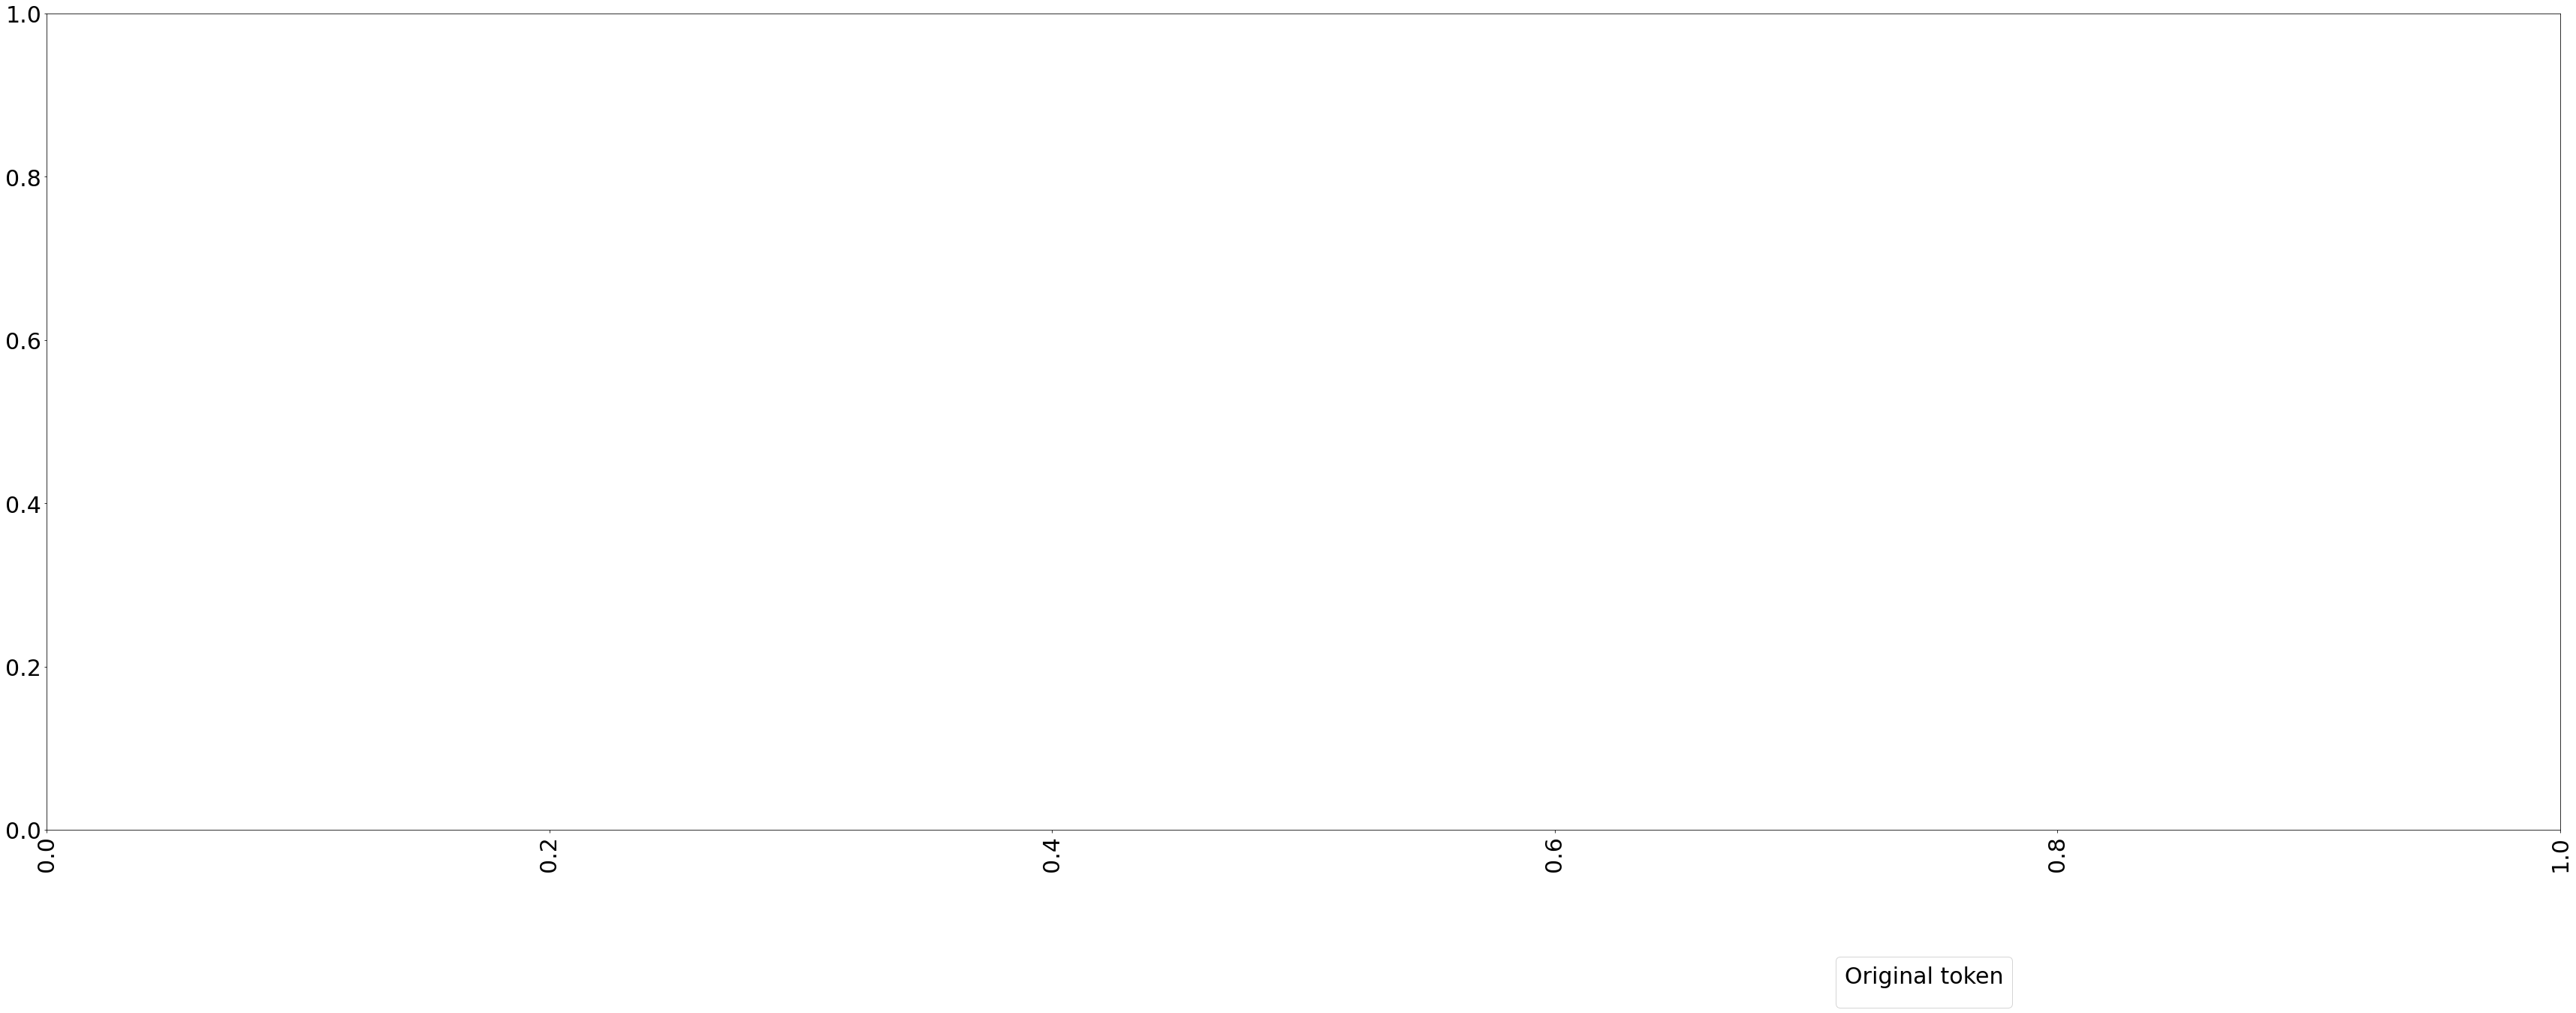

In [24]:
import textalloc as ta
plt.clf()
plt.figure(figsize=(60, 20))
plt.rcParams.update({'font.size': 30})
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
annotate_df = x_mutation_df.sort_values(f"abs_{pred_diff_col}", ascending=False)[:20]
ax = sns.stripplot(data=x_mutation_df, y="Human_pred_diff", x="perturb_seq_pos", hue="orig_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
x_mapping = {}
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="Original token")
ax.tick_params(axis='x', rotation=90)
for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]
text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])
ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [25]:
annotate_df

Empty DataFrame
Columns: [Cat, Chicken, Chinese rufous horseshoe bat, Ferret, Gray wolf, Horshoe bat, Human, Pig, uniref90_id, y_true, orig_token, perturb_pos, new_token, Human_pred_diff, abs_Human_pred_diff, orig_y_pred, new_y_pred, perturb_seq_pos, perturbation_id]
Index: []

## Known Mutations

In [26]:
s_mutations_file_path = os.path.join(os.getcwd(), "..", "..", "..","..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_WIV04_mutations_grouped_filtered.csv")
s_mutations_df = pd.read_csv(s_mutations_file_path)
s_mutations_df

spike_mutations                                      pango_lineage  \
0             A222V                                        ['B.1.177']   
1             A264D                                   ['JN.1', 'JN.4']   
2              A27S  ['BA.2', 'BA.2.12.1', 'BA.2.75', 'JN.1', 'BA.4...   
3             A475V  ['XBB.1.5', 'JD.1.1', 'JD.1.1.1', 'GW.5.1.1', ...   
4             A570D                                        ['B.1.1.7']   
..              ...                                                ...   
129            V83A  ['EG.5.1', 'XBB.1.5', 'JD.1.1', 'JD.1.1.1', 'J...   
130           W152C                               ['B.1.427, B.1.429']   
131           W152R                                        ['BA.2.75']   
132           Y248H                            ['XBB.1.5', 'JD.1.1.1']   
133           Y505H  ['BA.1', 'BA.2', 'BA.2.12.1', 'BA.2.75', 'JN.1...   

     variant_count  
0                1  
1                2  
2               27  
3                5  
4                1  
..             ...  
129             16  
130              1  
131              1  
132              2  
133             28  

[134 rows x 3 columns]

In [27]:
perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)

/tmp/ipykernel_2190225/742767506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df["perturbation_id"] = perturbed_output_df.apply(lambda x: f"{x['orig_token']}{x['perturb_seq_pos']}{x['new_token']}", axis=1)


In [28]:
known_mutations_df = perturbed_output_df[perturbed_output_df["perturbation_id"].isin(s_mutations_df["spike_mutations"])]
known_mutations_stats = known_mutations_df[["uniref90_id", "perturbation_id"]].groupby("perturbation_id").count().reset_index()
known_mutations_stats.rename(columns={"uniref90_id": "n_unique_sequences"}, inplace=True)
known_mutations_stats["percentage"] = known_mutations_stats["n_unique_sequences"] / 94 * 100
known_mutations_stats["label"] = known_mutations_stats.apply(lambda x: f"{x['perturbation_id']} (n={x['n_unique_sequences']} | {format(x['percentage'], '.2f')}%)", axis=1)
known_mutations_df = known_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], on="perturbation_id")

s_mutations_df = s_mutations_df.merge(known_mutations_stats[["perturbation_id", "label"]], right_on="perturbation_id", left_on="spike_mutations")
s_mutations_df["mutation_position"] = s_mutations_df["spike_mutations"].str.extract(r"[A-Z](\d+)[A-Z]").astype(int)

In [29]:
mutation_variant_heatmap_df = pd.read_csv(os.path.join(os.getcwd(), "..", "..", "..","..", "input/data/coronaviridae/20240313/wiv04/SARS_CoV_2_WIV04_mutations_filtered_heatmap.csv"))
mutation_variant_heatmap_df.set_index("spike_mutations", inplace=True)
mutation_variant_heatmap_df

B.1.1.1.C37  B.1.1.28.1  B.1.1.28.2  B.1.1.28.3  B.1.1.318  \
spike_mutations                                                               
A222V                    NaN         NaN         NaN         NaN        NaN   
A264D                    NaN         NaN         NaN         NaN        NaN   
A27S                     NaN         NaN         NaN         NaN        NaN   
A475V                    NaN         NaN         NaN         NaN        NaN   
A570D                    NaN         NaN         NaN         NaN        NaN   
...                      ...         ...         ...         ...        ...   
V83A                     NaN         NaN         NaN         NaN        NaN   
W152C                    NaN         NaN         NaN         NaN        NaN   
W152R                    NaN         NaN         NaN         NaN        NaN   
Y248H                    NaN         NaN         NaN         NaN        NaN   
Y505H                    NaN         NaN         NaN         NaN        NaN   

                 B.1.1.7  B.1.177  B.1.214.2  B.1.351  B.1.375  ...  HK.3.2  \
spike_mutations                                                 ...           
A222V                NaN      1.0        NaN      NaN      NaN  ...     NaN   
A264D                NaN      NaN        NaN      NaN      NaN  ...     NaN   
A27S                 NaN      NaN        NaN      NaN      NaN  ...     1.0   
A475V                NaN      NaN        NaN      NaN      NaN  ...     NaN   
A570D                1.0      NaN        NaN      NaN      NaN  ...     NaN   
...                  ...      ...        ...      ...      ...  ...     ...   
V83A                 NaN      NaN        NaN      NaN      NaN  ...     1.0   
W152C                NaN      NaN        NaN      NaN      NaN  ...     NaN   
W152R                NaN      NaN        NaN      NaN      NaN  ...     NaN   
Y248H                NaN      NaN        NaN      NaN      NaN  ...     NaN   
Y505H                NaN      NaN        NaN      NaN      NaN  ...     1.0   

                 HV.1  JD.1.1  JD.1.1.1  JG.3  JN.1  JN.4  XBB  XBB.1  XBB.1.5  
spike_mutations                                                                 
A222V             NaN     NaN       NaN   NaN   NaN   NaN  NaN    NaN      NaN  
A264D             NaN     NaN       NaN   NaN   1.0   1.0  NaN    NaN      NaN  
A27S              1.0     1.0       1.0   1.0   1.0   1.0  1.0    1.0      1.0  
A475V             NaN     1.0       1.0   NaN   NaN   1.0  NaN    NaN      1.0  
A570D             NaN     NaN       NaN   NaN   NaN   NaN  NaN    NaN      NaN  
...               ...     ...       ...   ...   ...   ...  ...    ...      ...  
V83A              1.0     1.0       1.0   1.0   NaN   NaN  1.0    1.0      1.0  
W152C             NaN     NaN       NaN   NaN   NaN   NaN  NaN    NaN      NaN  
W152R             NaN     NaN       NaN   NaN   NaN   NaN  NaN    NaN      NaN  
Y248H             NaN     NaN       1.0   NaN   NaN   NaN  NaN    NaN      1.0  
Y505H             1.0     1.0       1.0   1.0   1.0   NaN  1.0    1.0      1.0  

[134 rows x 45 columns]

<Figure size 432x288 with 0 Axes>

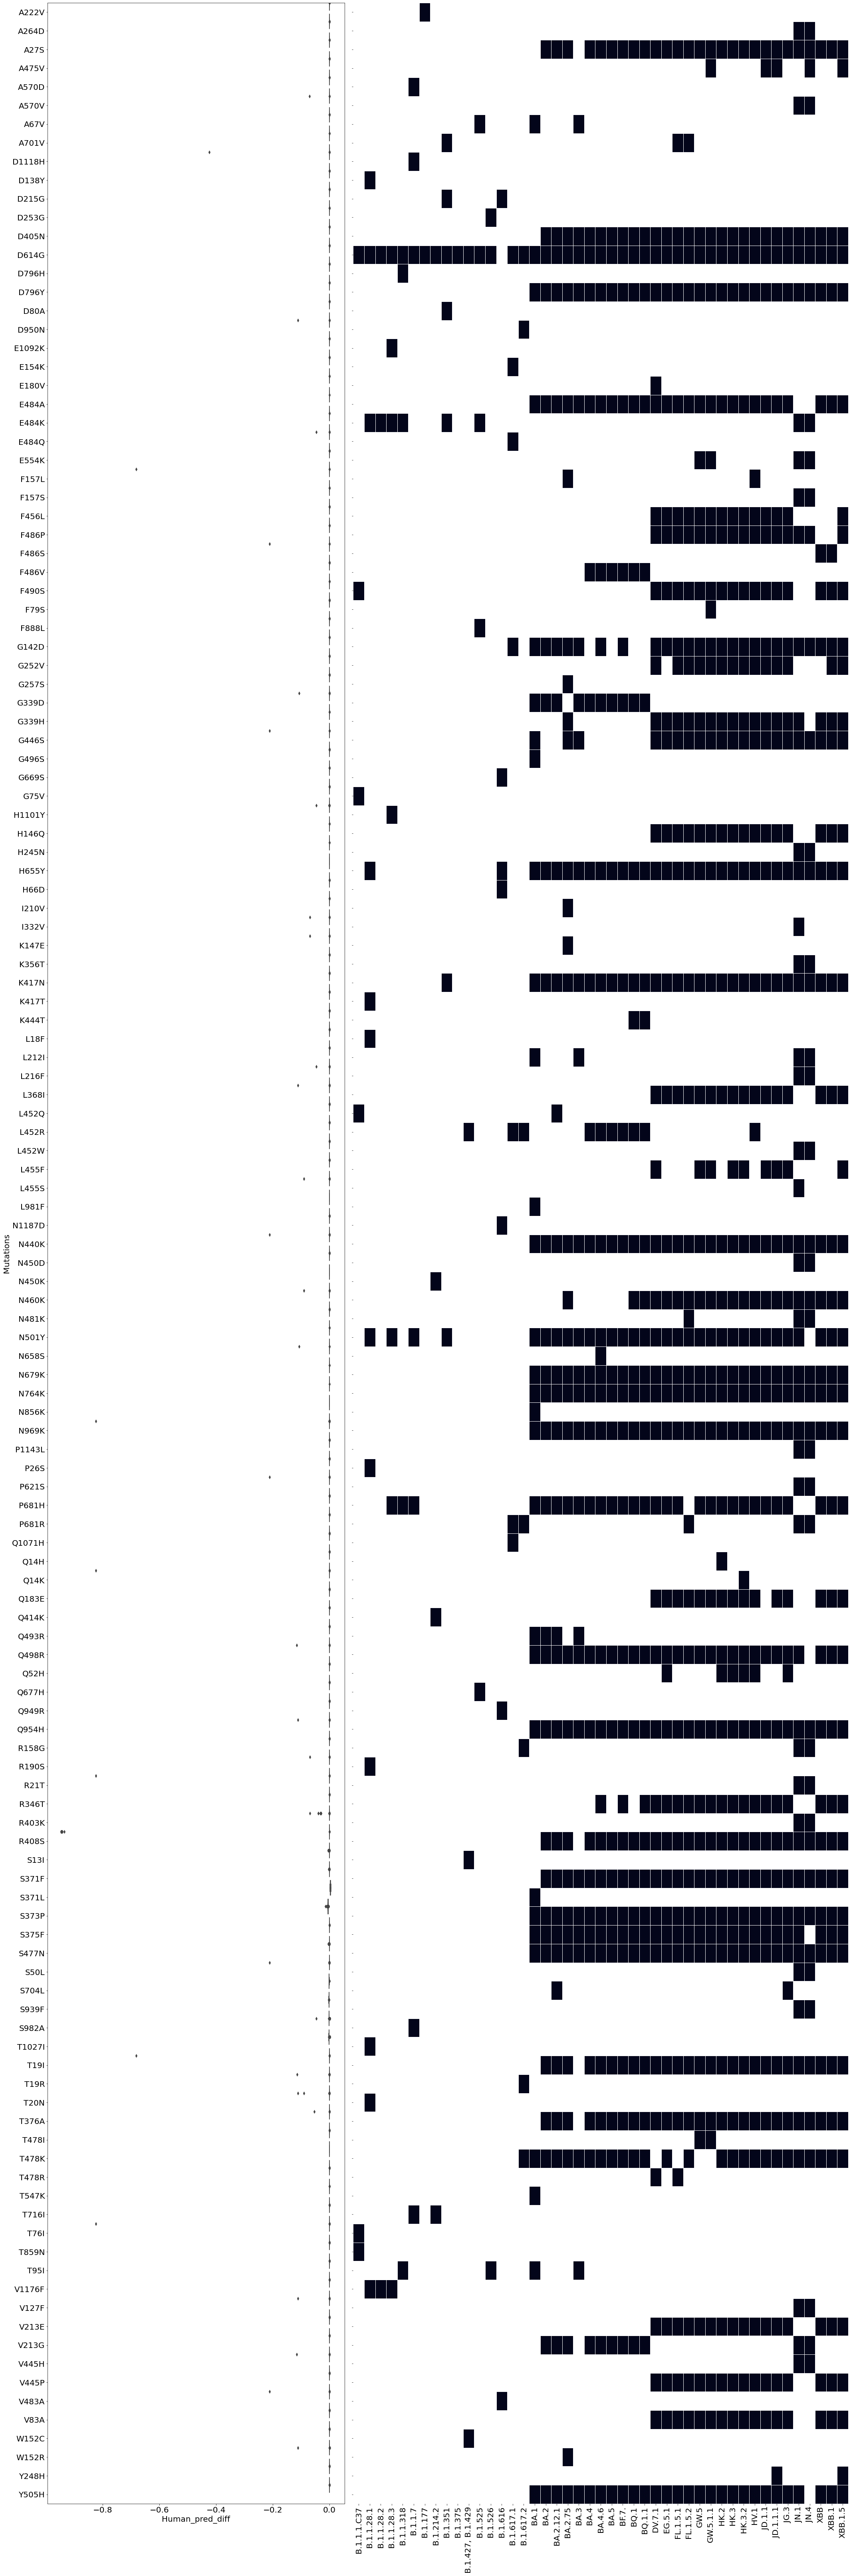

In [39]:
plt.clf()
plt.rcParams.update({'font.size': 20})
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

fig, axs = plt.subplots(1, 2, figsize=(30, 90), sharex=False, sharey=True, gridspec_kw={'width_ratios': [.6, 1]})


sns.boxplot(data=known_mutations_df, y="label", x="Human_pred_diff", 
                 order=known_mutations_df.sort_values("perturb_seq_pos")["label"].unique(),
                 boxprops={"facecolor": (.3, .5, .7, .5)}, ax=axs[0])
    
axs[0].set_ylabel("Mutations")
    #axs.tick_params(axis='x', rotation=90)
sns.heatmap(mutation_variant_heatmap_df, linewidth=.5, ax=axs[1], cmap=sns.cm.rocket_r, cbar=False, vmin=0, vmax=1)
# plt.tight_layout(pad=.2)
axs[1].set_ylabel("")
plt.tight_layout()
plt.show()

### Mutations with new token NOT = X

In [31]:
non_x_mutation_df = cut_off_df_2[(cut_off_df_2["new_token"] != "X") & (cut_off_df_2["orig_token"] != "X")].copy()
print(f"Non X = {non_x_mutation_df.shape}")
print(f"Number of unique mutations = {non_x_mutation_df['perturbation_id'].nunique()}")
annotate_df_pos = non_x_mutation_df.sort_values(by="Human_pred_diff", axis=0, ascending=False)[:10]
annotate_df_neg = non_x_mutation_df.sort_values("Human_pred_diff", axis=0)[:10]
annotate_df = pd.concat([annotate_df_pos, annotate_df_neg])

Non X = (8956, 19)
Number of unique mutations = 6301


<Figure size 432x288 with 0 Axes>

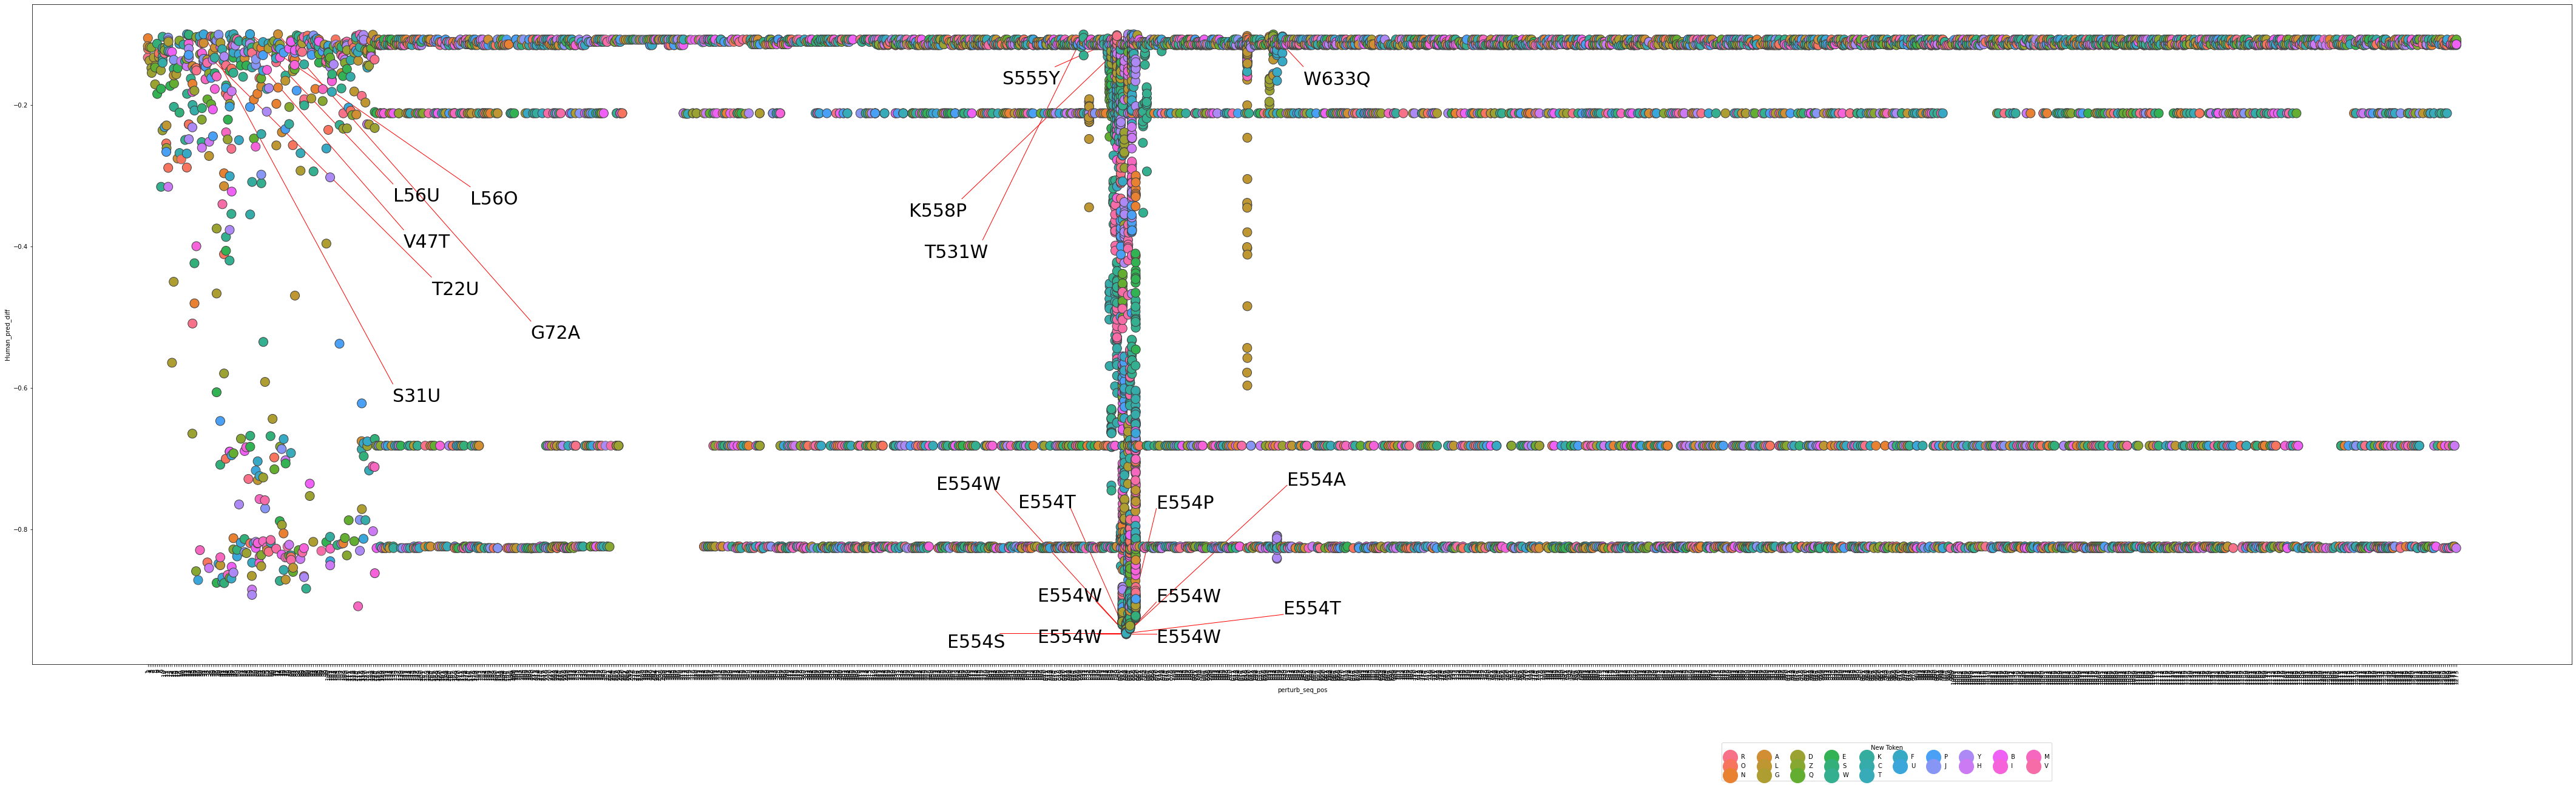

In [38]:
plt.clf()
plt.figure(figsize=(75, 20))
plt.rcParams.update({'font.size': 10})
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

ax = sns.stripplot(data=non_x_mutation_df, x="perturb_seq_pos", y="Human_pred_diff", hue="new_token", orient="v", s=15, linewidth=1)
ax.figure.canvas.draw()
plt.legend(bbox_to_anchor=(.8, -0.1), borderaxespad=2.0, markerscale=4., ncol=10, title="New Token")
ax.tick_params(axis='x', rotation=90)

x_mapping = {}

for i in ax.get_xticklabels():
    x_mapping[str(i.get_text())] = i.get_position()[0]

text_list = list(annotate_df["perturbation_id"].values)
x = []
y = []
for _, row in annotate_df.iterrows():
    x.append(x_mapping[str(row["perturb_seq_pos"])])
    y.append(row["Human_pred_diff"])

ta.allocate(ax, x, y, text_list, 
            x_scatter=[x_mapping[str(i)] for i in non_x_mutation_df["perturb_seq_pos"].values], 
            y_scatter=non_x_mutation_df[pred_diff_col].values, textsize=30)
plt.show()

In [33]:
cut_off_df_2["perturbation_id"].nunique()

6301

<Figure size 432x288 with 0 Axes>

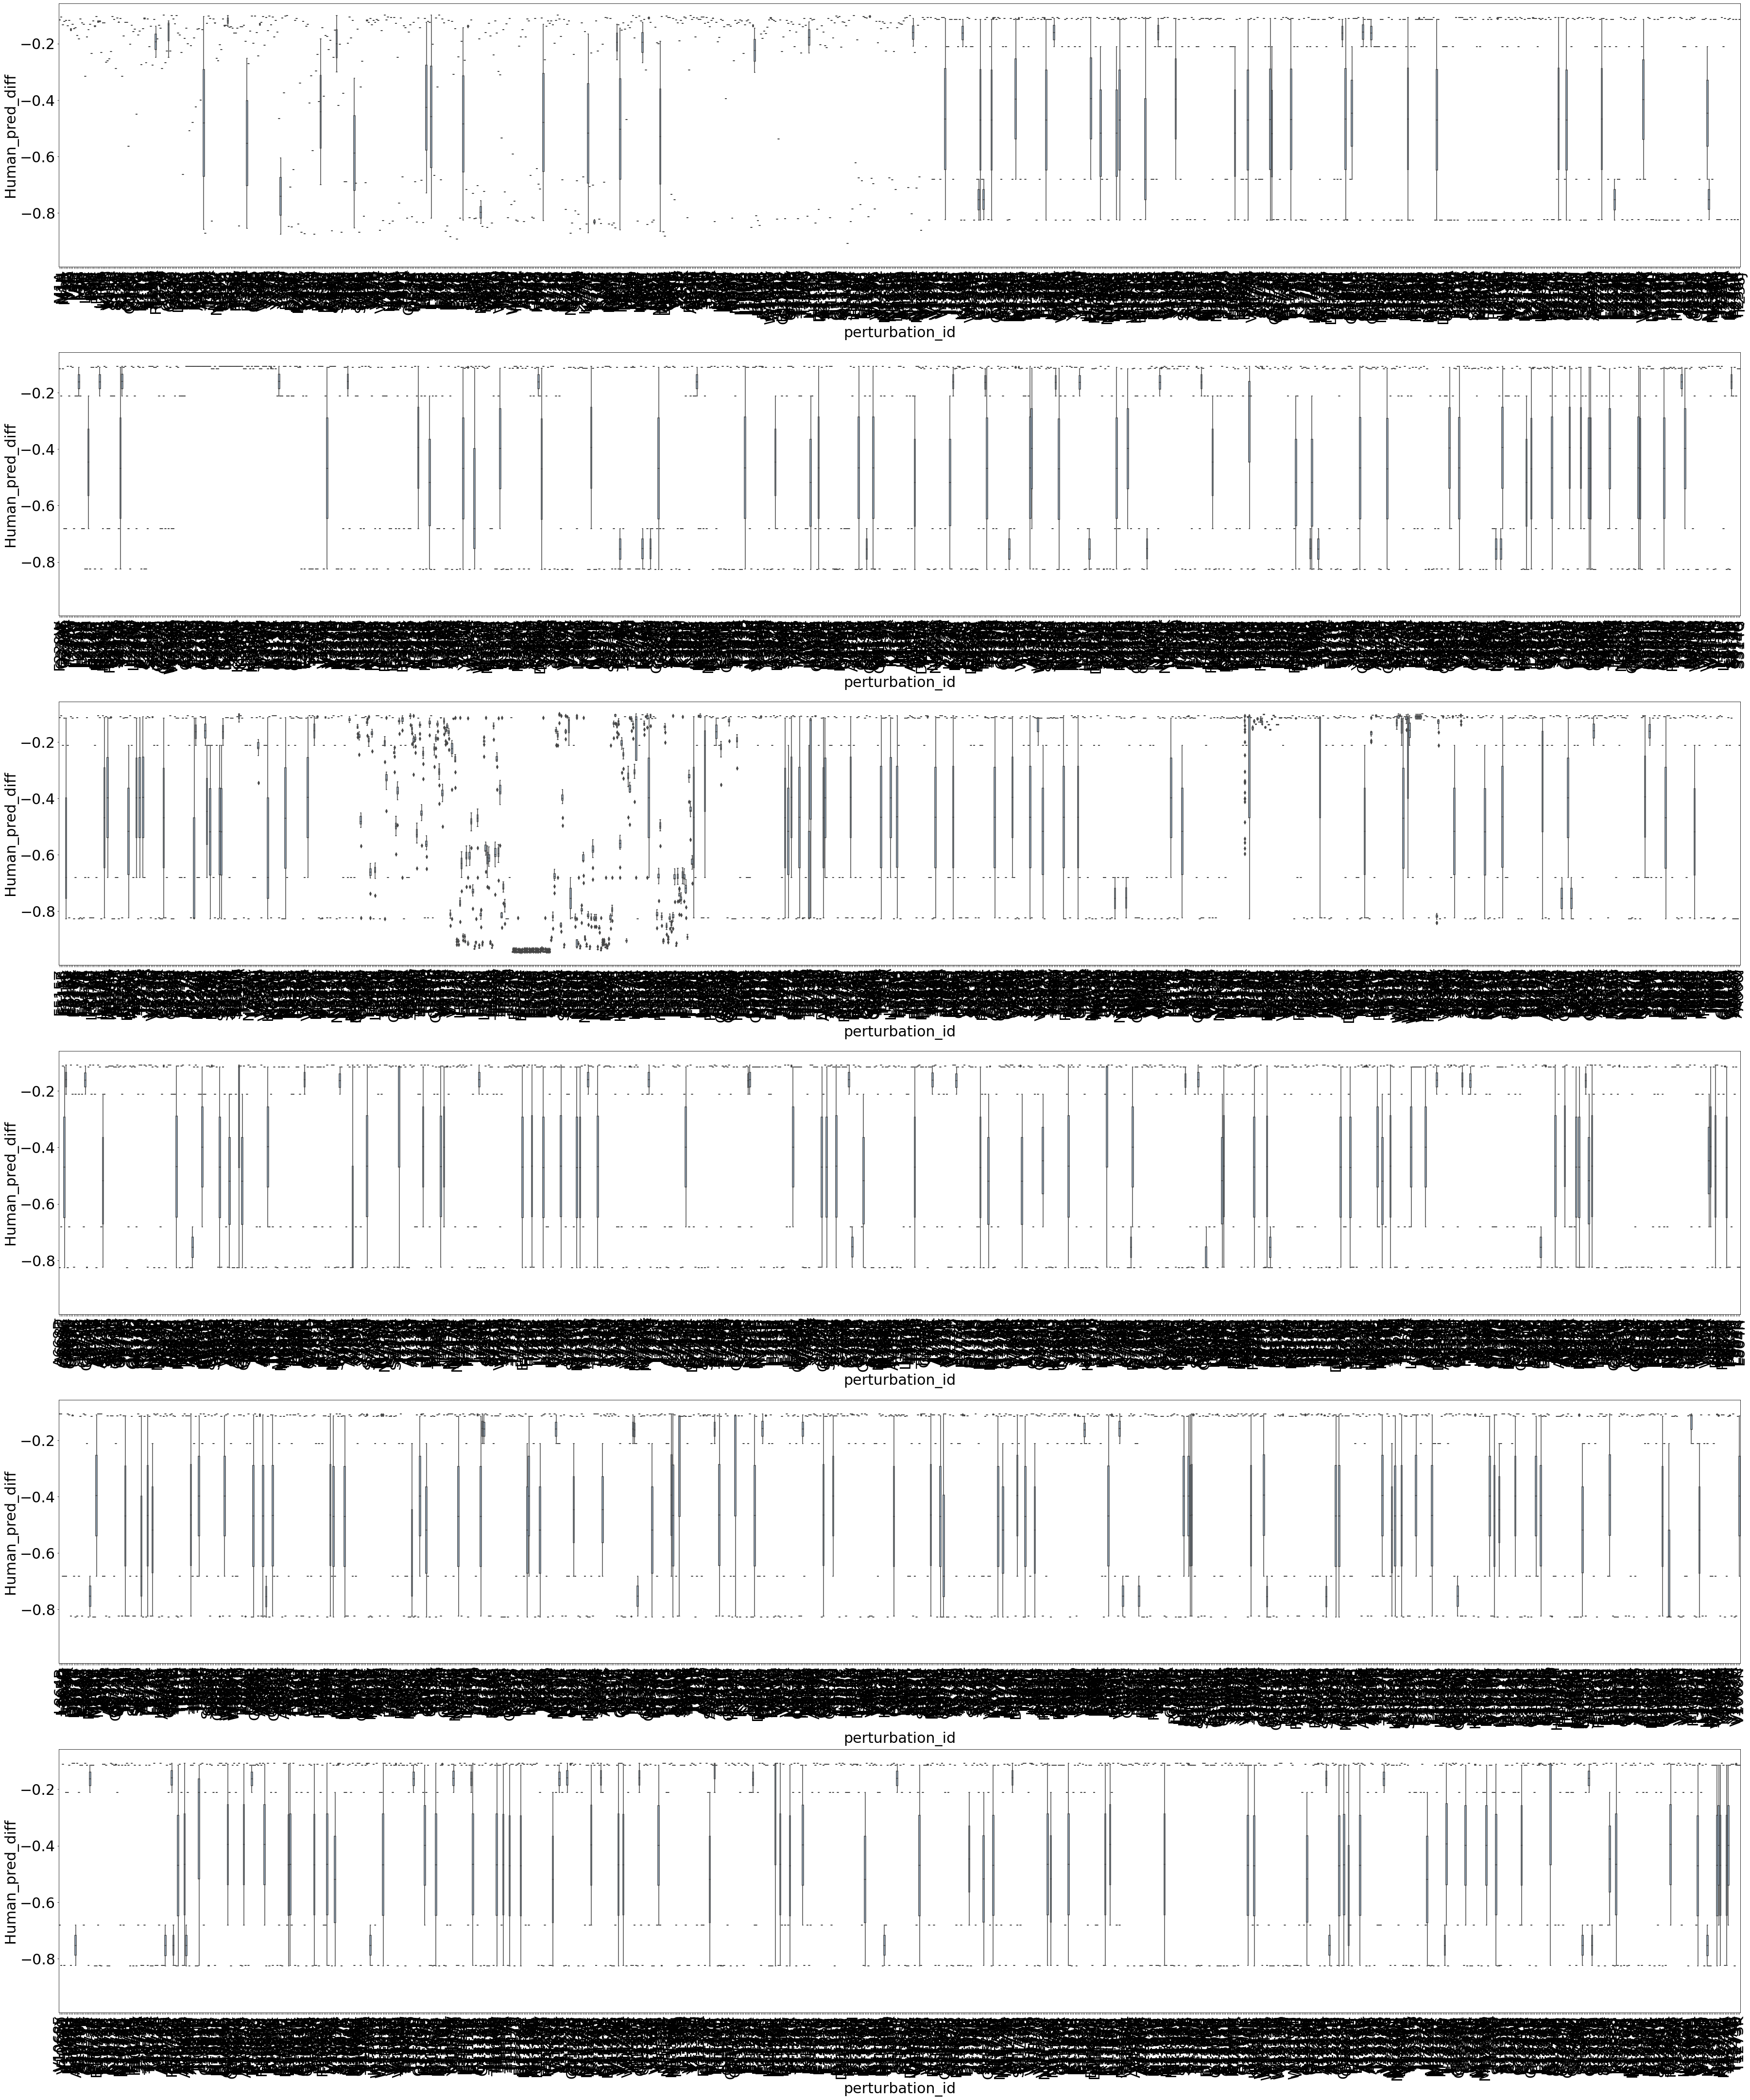

In [37]:
plt.clf()
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.rcParams.update({'font.size': 30})

perturbation_ids = cut_off_df_2.sort_values("perturb_seq_pos")["perturbation_id"].unique()
n = 6
fig, axs = plt.subplots(n, 1, figsize=(50, 60), sharex=False, sharey=True)

bins = get_uniformly_divided_position_bins(list(perturbation_ids), n)

for i in range(n):
    plot_df = cut_off_df_2[cut_off_df_2["perturbation_id"].isin(bins[i])]
    sns.boxplot(plot_df, x="perturbation_id", y=pred_diff_col, ax=axs[i], orient="v", order=bins[i],
               boxprops={"facecolor": (.3, .5, .7, .5)})
    axs[i].tick_params(axis='x', rotation=90)
    
plt.tight_layout(pad=.2)
plt.show()